In [5]:
import gym, math, tqdm, numpy as np, matplotlib.pyplot as plt

In [6]:
# Criando o ambiente
env_name = "MountainCar-v0"
env = gym.make(env_name)

In [7]:
# Definição de parâmetros
discrete = (10, 100)
num_eps = 3000
epsilon, min_epsilon = 0.0, 0.1

# Alpha corresponde à TAXA DE APRENDIZADO
learning_rate, min_learning_rate = 0.0, 0.3

discount_factor = 0.95
dec = 15

# Pode retornar os valores low[] e high[] direto do 'env', mas preferi colocar fixos aqui.
lower = [-1.2, -0.07]
upper = [0.6, 0.07]

# Inicializando a QTable
qtable = np.zeros(discrete + (env.action_space.n, ))

In [8]:
def choose_action(state):
    """
        O fator aleatório para melhorar o aprendizado
    """
    if (np.random.random() < epsilon):
        return env.action_space.sample()
    else:
        return np.argmax(qtable[state])
# ---------------------------------------------------------------------#
def discrete_state(state):
    """
        Recebe um espaço de observação (observation space) e o discretiza
    """
    d = list()

    for i in range(len(state)):
        stepsize = (state[i] + abs(lower[i])) / (upper[i] - lower[i])
        new_state = int(round((discrete[i] - 1) * stepsize))
        new_state = min(discrete[i] - 1, max(0, new_state))
        d.append(new_state)

    return tuple(d)
# ---------------------------------------------------------------------#
def get_epsilon(ep):
    # vai reduzindo o epsilon para diminuir a ganância do algoritmo
    # entretando, existe um valor mínimo que não reduz para garantir alguma aleatoriedade
    # reduz à medida que aumenta a quantidade de episódios
    # https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf
    return max(min_epsilon, min(1., 1. - math.log10((ep + 1) / dec)))
# ---------------------------------------------------------------------#
def get_learning_rate(ep):
    # vai reduzindo a taxa de aprendizagem para diminuir a ganância do algoritmo
    # entretando, existe um valor mínimo que não reduz para garantir algum aprendizado
    # reduz à medida que aumenta a quantidade de episódios
    # https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf
    return max(min_learning_rate, min(1., 1. - math.log10((ep + 1) / dec)))
# ---------------------------------------------------------------------#
def update_qtable(state1, action1, reward, state2, action2):
    qtable[state1][action1] += learning_rate * (reward + discount_factor * qtable[state2][action2] - qtable[state1][action1])

In [9]:
# Treinamento

# usado para plotar o gráfico de aprendizado
tr = []

# Treinamento SARSA
for ep in tqdm.tqdm(range(num_eps)):
    state1 = discrete_state(env.reset())
    action1 = choose_action(state1)

    learning_rate = get_learning_rate(ep)
    epsilon = get_epsilon(ep)
    done = False
    
    # usado para plotar o gráfico de aprendizado
    r = []

    while not done:
        # Pega o próximo estado, aka, S'
        obs, reward, done, _ = env.step(action1)
        state2 = discrete_state(obs)
        
        # Escolhe a ação futura baseada no estado futuro observado
        action2 = choose_action(state2)

        # Atualiza a QTable
        update_qtable(state1, action1, reward, state2, action2)

        state1 = state2
        action1 = action2

        r.append(reward)
        # fim WHILE

    env.close()
    tr.append(sum(r))
# fim FOR

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:26<00:00, 111.64it/s]


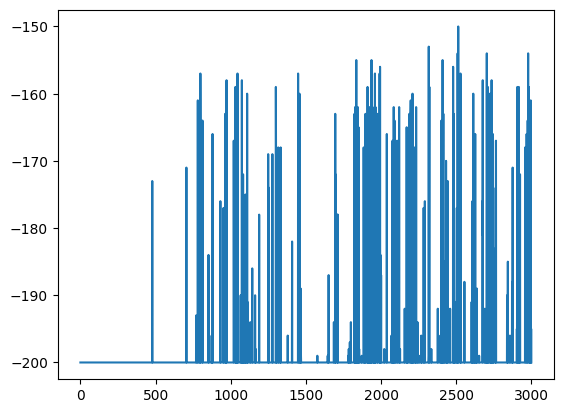

In [10]:
plt.plot(tr)

In [13]:
# Avaliando o treinamento dado

tr = []     # usado para plotar o histograma
i = 0       # macete para renderizar alguns episodios

# executando sempre para 10% de passos sobre o número total de episódios usados para treinamento
for _ in tqdm.tqdm(range(int(num_eps * 0.1))):
    
    # ambiente a ser avaliado
    env_t = gym.make(env_name)
    
    # usado para plotar o gráfico de aprendizado
    r = []

    done = False

    # estado atual
    cs = discrete_state(env_t.reset())

    while not done:
        
        # Renderizar os ultimos 5 episodios
        #if i >= (int(num_eps * 0.1) - 5):
            #env_t.render()

        action = np.argmax(qtable[cs])
        obs, reward, done, _ = env_t.step(action)
        new_state = discrete_state(obs)
        cs = new_state
        r.append(reward)
        # fim WHILE
        
    i += 1
    env_t.close()
    tr.append(sum(r))
# fim FOR

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:18<00:00, 15.96it/s]


(array([220.,  11.,   6.,   1.,   7.,   5.,   4.,  28.,  14.,   4.]),
 array([-200. , -195.3, -190.6, -185.9, -181.2, -176.5, -171.8, -167.1,
        -162.4, -157.7, -153. ]),
 <BarContainer object of 10 artists>)

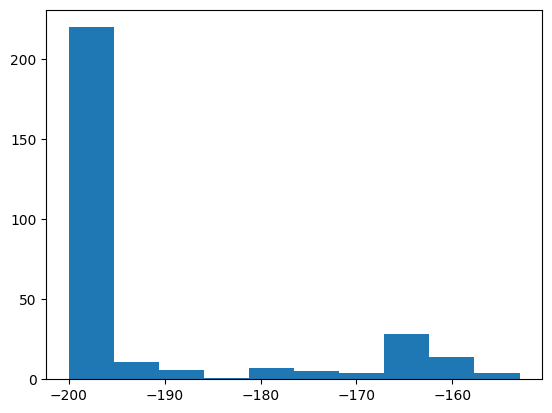

In [12]:
plt.hist(tr)